In [1]:
import glob 
import numpy as np 
import os 
import shutil 
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score

import matplotlib.pyplot as plt 

In [2]:
IM_SHAPE=(150,150)

In [3]:
filesCOV= glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/ALL/COVID-19/images/*')
filesNOCOV=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/ALL/Normal/images/*')


In [4]:
COVID = [fn for fn in filesCOV if 'covid' in fn] 
HEALTHY = [fn for fn in filesNOCOV if 'sano' in fn] 

len(COVID), len(HEALTHY)


(11956, 10701)

In [5]:
COVID_train = np.random.choice(filesCOV, size=5000, replace=False) 
HEALTHY_train = np.random.choice(filesNOCOV, size=5000, replace=False) 
filesCOV = list(set(filesCOV) - set(COVID_train)) 
filesNOCOV = list(set(filesNOCOV) - set(HEALTHY_train)) 
 
COVID_val = np.random.choice(filesCOV, size=1000, replace=False) 
HEALTHY_val = np.random.choice(filesNOCOV, size=1000, replace=False) 
filesCOV = list(set(filesCOV) - set(COVID_val)) 
filesNOCOV = list(set(filesNOCOV) - set(HEALTHY_val)) 
 
COVID_test = np.random.choice(filesCOV, size=1000, replace=False) 
HEALTHY_test = np.random.choice(filesNOCOV, size=1000, replace=False) 
 
print('Cat datasets:', COVID_train.shape, COVID_val.shape, COVID_test.shape) 
print('Dog datasets:', HEALTHY_train.shape, HEALTHY_val.shape, HEALTHY_test.shape) 

Cat datasets: (5000,) (1000,) (1000,)
Dog datasets: (5000,) (1000,) (1000,)


In [8]:
train_dir = 'D:/dataset/DATAOG/train' 
val_dir = 'D:/dataset/DATAOG/valid' 
test_dir = 'D:/dataset/DATAOG/test' 
 
    
train_files = np.concatenate([COVID_train, HEALTHY_train]) 
validate_files = np.concatenate([COVID_val, HEALTHY_val]) 
test_files = np.concatenate([COVID_test, HEALTHY_test])
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None 
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None 
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None 
 
for fn in train_files: 
    shutil.copy(fn, train_dir) 
for fn in validate_files: 
    shutil.copy(fn, val_dir) 
for fn in test_files: 
    shutil.copy(fn, test_dir)

In [9]:
test_files.shape

(2000,)

In [14]:
IMG_DIM = IM_SHAPE
 
train_files = glob.glob('D:/dataset/DATAOG/train/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img  
              in train_files] 
train_imgs = np.array(train_imgs) 
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                train_files] 

validation_files = glob.glob('D:/dataset/DATAOG/valid/*') 
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for 
                   img in validation_files] 
validation_imgs = np.array(validation_imgs) 
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                     validation_files] 
 
print('Train dataset shape:', train_imgs.shape,  
      'Validation dataset shape:', validation_imgs.shape) 

Train dataset shape: (10000, 150, 150, 3) Validation dataset shape: (2000, 150, 150, 3)


(150, 150, 3)


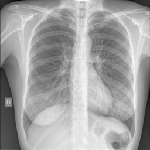

In [15]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0]) 

In [16]:
for i in range(10000):
    if train_labels[i].find("sano")==-1:
        train_labels[i]='covid'
    else :
        train_labels[i]='sano'
for i in range(2000):
    if validation_labels[i].find("sano")==-1:
        validation_labels[i]='covid'
    else :
        validation_labels[i]='sano'
        

In [17]:
batch_size = 30 
num_classes = 2 
epochs = 30 
input_shape = (IM_SHAPE[0],IM_SHAPE[1], 3) 
 
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[190:195], train_labels_enc[195:200]) 

['covid', 'covid', 'covid', 'covid', 'covid'] [0 0 0 0 0]


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

tf.debugging.set_log_device_placement(True)

In [18]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 
 
vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [19]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\hecto\AppData\Local\Temp\ipykernel_10156\1885812186.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001C7F8F35AF0>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C7F8DABE50>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C7F91E1400>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C7F9AB8550>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C7F9AB8070>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C7F9BF3640>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C7F9BCFE20>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C7F9BCFA30>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C7F9BF3D90>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001C7F9B20910>,block3_conv3,False


In [20]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


1/1 [==============================] - 4s 4s/step
(1, 4, 4, 512)


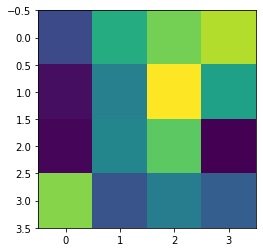

In [21]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [22]:
def get_bottleneck_features(model, input_imgs): 
    features = model.predict(input_imgs, verbose=0) 
    return features 

train_features_vgg = get_bottleneck_features(vgg_model, 
                                             train_imgs_scaled) 
validation_features_vgg = get_bottleneck_features(vgg_model,
                                                validation_imgs_scaled) 

print('Train Bottleneck Features:', train_features_vgg.shape,
      '\tValidation Bottleneck Features:', validation_features_vgg.shape) 

Train Bottleneck Features: (10000, 8192) 	Validation Bottleneck Features: (2000, 8192)


In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

In [28]:
X_train=train_features_vgg
y_train=train_labels_enc
X_valid=validation_features_vgg
y_valid=validation_labels_enc

In [29]:
hist=BaggingClassifier(
base_estimator=DecisionTreeClassifier(),
n_estimators=5
)
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[[883 117]
 [131 869]]
Accuracy:  0.876
Recall:  0.869
Precision:  0.8813387423935092
F1-score:  0.8751258811681774


In [30]:
hist=RandomForestClassifier(n_estimators=5)
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[[847 153]
 [168 832]]
Accuracy:  0.8395
Recall:  0.832
Precision:  0.8446700507614213
F1-score:  0.8382871536523929


In [31]:
hist=XGBClassifier()
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[[951  49]
 [ 79 921]]
Accuracy:  0.936
Recall:  0.921
Precision:  0.9494845360824742
F1-score:  0.9350253807106599


In [32]:
hist=LGBMClassifier(n_estimators=1000,class_weight='balanced',
                                       reg_alpha=0.1,reg_lambda=0.1,
                                       learning_rate=0.001,num_leaves=400,boosting='dart'
)
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[[905  95]
 [127 873]]
Accuracy:  0.889
Recall:  0.873
Precision:  0.9018595041322314
F1-score:  0.8871951219512195


In [33]:
hist=AdaBoostClassifier(
base_estimator=DecisionTreeClassifier(),
n_estimators=300
)
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[[825 175]
 [172 828]]
Accuracy:  0.8265
Recall:  0.828
Precision:  0.8255234297108675
F1-score:  0.8267598602096855


In [34]:
hist=DecisionTreeClassifier()
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[[837 163]
 [185 815]]
Accuracy:  0.826
Recall:  0.815
Precision:  0.8333333333333334
F1-score:  0.8240647118301314
